Initial dataframe shape: (1030, 9)
Using features: ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate ', 'age']
Target: concrete_compressive_strength
Dropped 0 rows with NaN
Samples (m) = 1030 Features (n) = 8
Train samples: 824 Test samples: 206
Epoch     1 | Loss: 1570.197519
Epoch   500 | Loss: 113.297044
Epoch  1000 | Loss: 111.931607
Epoch  1500 | Loss: 111.324413
Epoch  2000 | Loss: 111.005243
Epoch  2500 | Loss: 110.836022
Epoch  3000 | Loss: 110.746267
Epoch  3500 | Loss: 110.698660
Epoch  4000 | Loss: 110.673409
Epoch  4500 | Loss: 110.660015
Epoch  5000 | Loss: 110.652911
Training finished. Final loss: 110.652911283503
Test MSE: 95.945768 | Test R^2: 0.627651


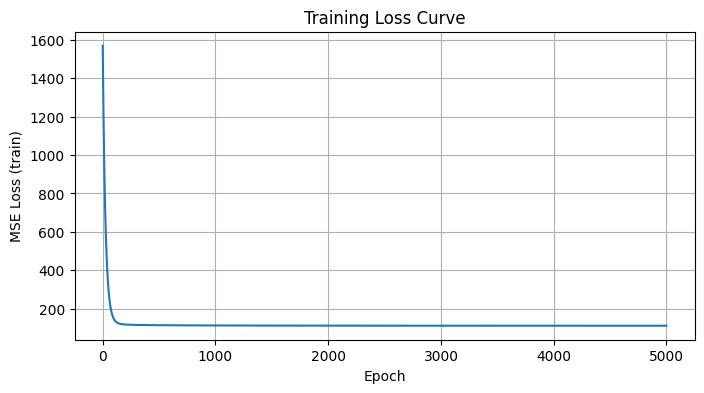

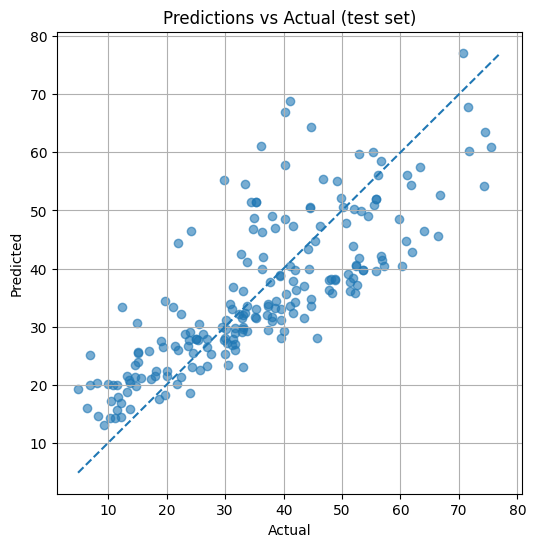

actual: 52.9100 | predicted: 59.6966
actual: 55.9000 | predicted: 51.9816
actual: 74.5000 | predicted: 63.5422
actual: 35.3000 | predicted: 51.5164
actual: 10.5400 | predicted: 17.2108
actual: 44.2800 | predicted: 39.9139
actual: 23.6900 | predicted: 26.7141
actual: 45.3700 | predicted: 44.7223


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline


csv_path = "concrete_data.csv"    
target_col = "concrete_compressive_strength"   
feature_cols = None     
random_state = 42
n_epochs = 5000
lr = 0.01
print_every = 500



df = pd.read_csv(csv_path)
print("Initial dataframe shape:", df.shape)

for col in ["Unnamed: 0", "ID", "Serial No.", "Index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

if feature_cols is None:
    if target_col not in df.columns:
        raise ValueError(f"target_col'{target_col}' not found in dataframe columns: {df.columns.tolist()}")
    X_df = df.drop(columns=[target_col]).copy()
    y_df = df[[target_col]].copy()
else:
    X_df = df[feature_cols].copy()
    y_df = df[[target_col]].copy()

print("Using features:", X_df.columns.tolist())
print("Target:", target_col)

before = len(df)
data = pd.concat([X_df, y_df], axis=1).dropna()
after = len(data)
print(f"Dropped {before-after} rows with NaN")

X_df = data[X_df.columns]
y_df = data[[target_col]]

X_mean = X_df.mean()
X_std = X_df.std(ddof=0).replace(0, 1.0)  
X_scaled = (X_df - X_mean) / X_std

X = X_scaled.to_numpy(dtype=float)  
y = y_df.to_numpy(dtype=float)       
m, n = X.shape
print("Samples (m) =", m, "Features (n) =", n)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
m_train = X_train.shape[0]
print("Train samples:", m_train, "Test samples:", X_test.shape[0])

rng = np.random.default_rng(seed=random_state)
theta = rng.normal(loc=0.0, scale=0.01, size=(n, 1)) 
bias = 0.0

losses = []
for epoch in range(1, n_epochs+1):
    
    y_pred = X_train.dot(theta) + bias             
    error = y_pred - y_train                        

    loss = (1.0 / m_train) * np.sum(error ** 2)
    losses.append(loss)

    grad_theta = (2.0 / m_train) * (X_train.T.dot(error))   
    grad_bias  = (2.0 / m_train) * np.sum(error)           

    theta = theta - lr * grad_theta
    bias = bias - lr * grad_bias

    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | Loss: {loss:.6f}")

print("Training finished. Final loss:", losses[-1])

y_test_pred = X_test.dot(theta) + bias
mse_test = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse_test:.6f} | Test R^2: {r2:.6f}")

plt.figure(figsize=(8,4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (train)")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
minv = min(y_test.min(), y_test_pred.min())
maxv = max(y_test.max(), y_test_pred.max())
plt.plot([minv, maxv], [minv, maxv], linestyle='--')   
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predictions vs Actual (test set)")
plt.grid(True)
plt.show()

for i in range(min(8, len(y_test))):
    print(f"actual: {y_test[i,0]:.4f} | predicted: {y_test_pred[i,0]:.4f}")


In [7]:
# best learning rate search

candidates = [0.0005, 0.001, 0.005, 0.01, 0.05]
best = None
for candidate_lr in candidates:
    theta_tmp = rng.normal(0, 0.01, size=(n,1))
    bias_tmp = 0.0
    for e in range(300):  
        pred = X_train.dot(theta_tmp) + bias_tmp
        err = pred - y_train
        theta_tmp = theta_tmp - candidate_lr * (2.0/m_train) * (X_train.T.dot(err))
        bias_tmp  = bias_tmp - candidate_lr * (2.0/m_train) * np.sum(err)
    yval = X_test.dot(theta_tmp) + bias_tmp
    mse_val = mean_squared_error(y_test, yval)
    print(f"lr={candidate_lr} -> test MSE (300 epochs) = {mse_val:.6f}")
    if best is None or mse_val < best[0]:
        best = (mse_val, candidate_lr)
print("Best quick lr:", best)


lr=0.0005 -> test MSE (300 epochs) = 887.022458
lr=0.001 -> test MSE (300 epochs) = 536.100325
lr=0.005 -> test MSE (300 epochs) = 106.848407
lr=0.01 -> test MSE (300 epochs) = 100.020100
lr=0.05 -> test MSE (300 epochs) = 96.208826
Best quick lr: (96.20882551220997, 0.05)
